In [1]:
#contract labor exploration

In [2]:
#dependencies
import pandas as pd
import requests
import json
import scipy.stats as st
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import tensorflow
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import joblib

In [3]:
# ... File Imports

In [4]:
#2017 Hospital Data from Centers for Medicare Services
df = pd.read_csv("Medicare_Hospital_Cost_Report_PUF_2017.csv")
df.head(2)

C:\Users\rodge\anaconda3\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (105) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Provider CCN,Hospital Name,Street Address,City,State Code,Zip Code,County,Medicare CBSA Number,Rural Versus Urban,CCN Facility Type,...,Total Other Income,Total Income,Total Other Expenses,Net Income,Cost To Charge Ratio,Net Revenue from Medicaid,Medicaid Charges,Net Revenue from Stand-Alone SCHIP,Stand-Alone SCHIP Charges,rpt_rec_num
0,510013,REYNOLDS MEMORIAL HOSPITAL,800 WHEELING AVENUE,GLEN DALE,WV,26038,MARSHALL,48540.0,U,STH,...,4492364.0,2638799.0,NaN,2638799.0,0.453498,1237912.0,4026663.0,NaN,NaN,599181
1,340106,SANDHILLS REGIONAL MEDICAL CENTER,1000 WEST HAMLET AVE,HAMLET,NC,28345,RICHMOND,99934.0,R,STH,...,31174.0,-1114660.0,NaN,-1114660.0,0.173114,391215.0,4981119.0,NaN,NaN,601095


In [5]:
#Quick Check
df['Provider CCN'].nunique()

6075

In [6]:
#Quick Check
df['Provider CCN'].count()

6171

In [7]:
df.drop_duplicates(inplace = True)
df['Provider CCN'].count()

6171

In [8]:
#Certificate of Need Status by State File
conTable = pd.read_csv("certificateofneedstatesTable.csv")
conTable.head(2)

,State Code,CON
0,AK,1
1,AL,1


In [9]:
#String to Numeric Conversion Table for Urban v. Rural designation
urbanTable = pd.read_csv("ruralversusurbanTable.csv")
urbanTable.head()

,Rural Versus Urban,Urban
0,U,1
1,R,0


In [10]:
#Lattitude & Longitude for the 2017 hospital listing
geoTable = pd.read_csv("ccn2geocode.csv")
geoTable.head(2)

,Provider CCN,lat,lng
0,10001,31.215884,-85.363008
1,10005,34.222103,-86.160908


In [11]:
#Quick Check
geoTable['Provider CCN'].count()

6075

In [12]:
# ... Appending of source files into one main working file

In [13]:
mainFile1 = df

In [14]:
#Append lattitude & longitude
mainFile1 = pd.merge(mainFile1, geoTable, how= "left", on=['Provider CCN'])
mainFile1.head(2)

,Provider CCN,Hospital Name,Street Address,City,State Code,Zip Code,County,Medicare CBSA Number,Rural Versus Urban,CCN Facility Type,...,Total Other Expenses,Net Income,Cost To Charge Ratio,Net Revenue from Medicaid,Medicaid Charges,Net Revenue from Stand-Alone SCHIP,Stand-Alone SCHIP Charges,rpt_rec_num,lat,lng
0,510013,REYNOLDS MEMORIAL HOSPITAL,800 WHEELING AVENUE,GLEN DALE,WV,26038,MARSHALL,48540.0,U,STH,...,NaN,2638799.0,0.453498,1237912.0,4026663.0,NaN,NaN,599181,39.946236,-80.752966
1,340106,SANDHILLS REGIONAL MEDICAL CENTER,1000 WEST HAMLET AVE,HAMLET,NC,28345,RICHMOND,99934.0,R,STH,...,NaN,-1114660.0,0.173114,391215.0,4981119.0,NaN,NaN,601095,34.901612,-79.708561


In [15]:
#Quick Check
mainFile1['Provider CCN'].count()

6171

In [16]:
#Append certificate of need indicator
mainFile1 = pd.merge(mainFile1, conTable, how= "left", on=['State Code'])

In [17]:
#Quick Check
mainFile1['Provider CCN'].count()

6171

In [18]:
#Append a numeric representation of rural v. urban
mainFile1 = pd.merge(mainFile1, urbanTable, how= "left", on=['Rural Versus Urban'])

In [19]:
#Quick Check
mainFile1['Contract Labor'].count()

3119

In [20]:
mainFile1.head(2)

,Provider CCN,Hospital Name,Street Address,City,State Code,Zip Code,County,Medicare CBSA Number,Rural Versus Urban,CCN Facility Type,...,Cost To Charge Ratio,Net Revenue from Medicaid,Medicaid Charges,Net Revenue from Stand-Alone SCHIP,Stand-Alone SCHIP Charges,rpt_rec_num,lat,lng,CON,Urban
0,510013,REYNOLDS MEMORIAL HOSPITAL,800 WHEELING AVENUE,GLEN DALE,WV,26038,MARSHALL,48540.0,U,STH,...,0.453498,1237912.0,4026663.0,NaN,NaN,599181,39.946236,-80.752966,1.0,1.0
1,340106,SANDHILLS REGIONAL MEDICAL CENTER,1000 WEST HAMLET AVE,HAMLET,NC,28345,RICHMOND,99934.0,R,STH,...,0.173114,391215.0,4981119.0,NaN,NaN,601095,34.901612,-79.708561,1.0,0.0


In [21]:
mainFile1.to_csv("contractLabor1.csv", index=False, header=True)

In [22]:
# ... Add calculated fields

In [23]:
mainFile2 = mainFile1

In [24]:
#labor Expense
lbrexpense = mainFile2["Wage-Related Costs (Core)"] + mainFile2["Total Salaries (adjusted)"]
mainFile2["Labor Exp"] = lbrexpense
#wagepercent.head()

In [25]:
#Append calculated field inpatient percent
inpatient = mainFile2["Inpatient Revenue"]/mainFile2["Gross Revenue"]
mainFile2["Inpatient %"] = inpatient

In [26]:
#Append calculated field outpatient percent
outpatient = mainFile2["Outpatient Revenue"]/mainFile2["Gross Revenue"]
mainFile2["Outpatient %"] = outpatient

In [27]:
#Append calculated field charity percent
charity = mainFile2["Cost of Charity Care"]/mainFile2["Net Patient Revenue"]
mainFile2["Charity %"] = charity

In [28]:
#Append calculated field uncompensated percent
uncompensated = mainFile2["Cost of Uncompensated Care"]/mainFile2["Net Patient Revenue"]
mainFile2["Uncompensated %"] = charity

In [29]:
#Append calculated field revenue per discharge
revdischarge = mainFile2["Net Patient Revenue"]/mainFile2["Total Discharges (V + XVIII + XIX + Unknown)"]
mainFile2["Rev/Discharge"] = revdischarge

In [30]:
#Append calculated field revenue per bed
revbed = mainFile2["Net Patient Revenue"]/mainFile2["Number of Beds"]
mainFile2["Rev Per Bed"] = revbed

In [31]:
#Append calculated field revenue per bed day
revbed = mainFile2["Net Patient Revenue"]/mainFile2["Total Bed Days Available"]
mainFile2["Rev Per Bed Days"] = revbed

In [32]:
#Append calculated field revs per fte
revfte = mainFile2["Net Patient Revenue"]/mainFile2["FTE - Employees on Payroll"]
mainFile2["Rev Per FTE"] = revfte

In [33]:
#Append calculated field discharges per bed
volbed = mainFile2["Total Discharges (V + XVIII + XIX + Unknown)"]/mainFile2["Number of Beds"]
mainFile2["Discharges Per Bed"] = volbed

In [34]:
#Append calculated field discharges per bed day
voldays = mainFile2["Total Discharges (V + XVIII + XIX + Unknown)"]/mainFile2["Total Bed Days Available"]
mainFile2["Discharges Per Bed Days"] = voldays

In [35]:
#Append calculated field discharges per bed
volfte = mainFile2["Total Discharges (V + XVIII + XIX + Unknown)"]/mainFile2["FTE - Employees on Payroll"]
mainFile2["Discharge/FTE"] = volbed

In [36]:
#labor percent
wagepercent = mainFile2["Wage-Related Costs (Core)"] + mainFile2["Total Salaries (adjusted)"]
wagepercent = wagepercent / mainFile2["Net Patient Revenue"]
mainFile2["Labor %"] = wagepercent

In [37]:
#Overhead percent
overheadpercent = mainFile2["Overhead Non-Salary Costs"] / mainFile2["Net Patient Revenue"]
mainFile2["Overhead %"] = overheadpercent

In [38]:
#Depreciation percent
deprpercent = mainFile2["Depreciation Cost"] / mainFile2["Net Patient Revenue"]
mainFile2["Depreciation %"] = deprpercent

In [39]:
#labor Per FTE
wagefte = mainFile2["Wage-Related Costs (Core)"] + mainFile2["Total Salaries (adjusted)"]
wagefte = wagefte / mainFile2["FTE - Employees on Payroll"]
mainFile2["LbrExp/FTE"] = wagefte

In [40]:
#Overhead Expense Per Bed
overbed = mainFile2["Overhead Non-Salary Costs"] / mainFile2["Number of Beds"]
mainFile2["Overhead Exp Per Bed"] = overbed

In [41]:
#Append calculated field net income percent to file
profit = mainFile2["Net Income"]/mainFile2["Net Patient Revenue"]
mainFile2["Net Income %"] = profit

In [42]:
#Append calculated field net income percent to file
traveler = mainFile2["Contract Labor"] / (mainFile2["Wage-Related Costs (Core)"] + mainFile2["Total Salaries (adjusted)"])
mainFile2["Contract Labor / Labor Exp %"] = profit

In [43]:
#Append calculated field net income percent to file
mercenary = mainFile2["Contract Labor"]/mainFile2["Net Patient Revenue"]
mainFile2["Contract Labor / Revenue %"] = profit

In [44]:
# Review net income percent for outlier reduction approach
mercenary = mainFile2["Contract Labor"]

In [45]:
# Creating variable for quartile work
mercenary2 = mercenary.dropna(how='any')
chartdata = mercenary2

In [46]:
#Quartile calculations
quartiles = chartdata.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile is: {lowerq}")
print(f"The upper quartile is: {upperq}")
print(f"The interquartile range  is: {iqr}")
print(f"The the median is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile is: 473265.5
The upper quartile is: 3586928.0
The interquartile range  is: 3113662.5
The the median is: 1394141.0 
Values below -4197228.25 could be outliers.
Values above 8257421.75 could be outliers.


In [47]:
#Create a bronze, silver, gold score for clasifying net income performance
bins = [-5000000, 3000000, 100000000]
group_names = ["0", "1"]

In [48]:
#Add a bronze, silver, gold scoring system to the dataset to support machine learning
mainFile2["Traveler Score"] = pd.cut(mainFile2["Contract Labor"], bins, labels=group_names, include_lowest=True)
#mainFile2.head()

In [84]:
#Quick check on distribution of bronze, silver and gold
mainFile2['Traveler Score'].value_counts()

0    2223
1     891
Name: Traveler Score, dtype: int64

In [85]:
#Traveling Spend
bins2 = [-10000000000, 475000, 1400000,  3600000, 100000000000]
group_names2 = ["4th Quartile", "3rd Quartile", "2nd Quartile", "1st Quartile"]

In [86]:
# Add Pacesetter Status to dataframe
mainFile2["Traveler Spend"] = pd.cut(mainFile2["Contract Labor"], bins2, labels=group_names2, include_lowest=True)
# #mainFile2.head()

In [88]:
mainFile2['Traveler Spend'].value_counts()

3rd Quartile    783
4th Quartile    782
1st Quartile    778
2nd Quartile    776
Name: Traveler Spend, dtype: int64

In [53]:
#Quick Check
mainFile1['Contract Labor'].count()

3119

In [54]:
#Quick Check
mainFile2['Provider CCN'].count()

6171

In [55]:
mainFile2.to_csv("contractLabor2.csv", index=False, header=True)

In [56]:
# ..... File targeting

In [57]:
mainFile3 = mainFile2

In [58]:
#Remove the Sitka exceptions (addresses that did not match when called in API)
mainFile3 = mainFile3.loc[mainFile3['lat'] <= 48.85]

In [59]:
#Removes state
mainFile3 = mainFile3.loc[mainFile3['State Code'] != 'PR']

In [60]:
#Removes state
mainFile3 = mainFile3.loc[mainFile3['State Code'] != 'GU']

In [61]:
#Removes state
mainFile3 = mainFile3.loc[mainFile3['State Code'] != 'VI']

In [62]:
#Removes state
mainFile3 = mainFile3.loc[mainFile3['State Code'] != 'MP']

In [63]:
#Removes state
mainFile3 = mainFile3.loc[mainFile3['State Code'] != 'HI']

In [64]:
#Removes state
mainFile3 = mainFile3.loc[mainFile3['State Code'] != 'AK']

In [65]:
#Quick Check ... Lose 117 to state code reduction
mainFile3['Provider CCN'].count()

6026

In [66]:
#Quick Check
mainFile1['Contract Labor'].count()

3119

In [67]:
#Remove hospitals that did not report revenue (Lose 273 to missing or unreported revenue events)
mainFile3 = mainFile3.loc[mainFile3['Net Patient Revenue'] >= 0.1]

In [68]:
#Remove hospitals that discharged less than 15 patients (Lose 49 by placing a 15 patient minimum for study eligibility)
mainFile3 = mainFile3.loc[mainFile3['Total Discharges (V + XVIII + XIX + Unknown)'] >= 15]

In [69]:
#Remove hospitals with less than 10 employees on payroll (Lose 23 by placing a 10 employee minimum for study eligibility)
mainFile3 = mainFile3.loc[mainFile3['FTE - Employees on Payroll'] >= 10]

In [70]:
#Remove hospitals that did not report revenue (Lose 273 to missing or unreported revenue events)
mainFile3 = mainFile3.loc[mainFile3['Contract Labor'] >= 0.1]

In [71]:
#Targets dataset on STH locations (~56% of eligible continental US locations are STH providers)
mainFile3 = mainFile3.loc[mainFile3['CCN Facility Type'] == 'STH']

In [72]:
#Quick Check
mainFile3['Provider CCN'].count()

2850

In [73]:
#Quick Check
mainFile1['Contract Labor'].count()

3119

In [74]:
#mainFile3.to_csv("contractLabor3", index=False, header=True)

In [75]:
# ... Target file based on relevant features

In [76]:
mainFile4 = mainFile3

In [77]:
#Targeting the dataset on metrics based on Kent's judgement
mainFile4 = mainFile4[['Provider CCN','Hospital Name','Street Address','City','State Code','Zip Code', 'lat', 'lng', 'Rural Versus Urban', 'CCN Facility Type', 'Fiscal Year Begin Date', 'Fiscal Year End Date', 'FTE - Employees on Payroll', 'Number of Beds', 'Total Bed Days Available', 'Total Discharges (V + XVIII + XIX + Unknown)', 'Net Patient Revenue', 'Net Income', 'Wage-Related Costs (Core)', 'Total Salaries (adjusted)', 'Contract Labor', 'Rev Per FTE', 'CON','Urban','Inpatient %','Outpatient %','Charity %','Uncompensated %','Rev/Discharge','Rev Per Bed','Rev Per Bed Days', 'Discharges Per Bed','Discharges Per Bed Days','Discharge/FTE','Net Income %', 'Labor %', 'Overhead %', 'Depreciation %', 'LbrExp/FTE', 'Overhead Exp Per Bed', 'Traveler Score', 'Contract Labor / Labor Exp %', 'Contract Labor / Revenue %', 'Traveler Spend']]
mainFile4.head(2)


,Provider CCN,Hospital Name,Street Address,City,State Code,Zip Code,lat,lng,Rural Versus Urban,CCN Facility Type,...,Net Income %,Labor %,Overhead %,Depreciation %,LbrExp/FTE,Overhead Exp Per Bed,Traveler Score,Contract Labor / Labor Exp %,Contract Labor / Revenue %,Traveler Spend
1,340106,SANDHILLS REGIONAL MEDICAL CENTER,1000 WEST HAMLET AVE,HAMLET,NC,28345,34.901612,-79.708561,R,STH,...,-0.337043,0.509928,0.924882,0.073496,61909.838473,47792.984375,0,-0.337043,-0.337043,4th Quartile
2,450178,PECOS COUNTY MEMORIAL HOSPITAL,386 W IH-10,FORT STOCKTON,TX,79735,30.567794,-87.393012,R,STH,...,0.232354,0.967445,0.813624,0.104039,16085.224911,80717.240000,0,0.232354,0.232354,4th Quartile


In [78]:
# Identify incomplete rows
mainFile4.count()

Provider CCN                                    2850
Hospital Name                                   2850
Street Address                                  2850
City                                            2850
State Code                                      2850
Zip Code                                        2850
lat                                             2850
lng                                             2850
Rural Versus Urban                              2850
CCN Facility Type                               2850
Fiscal Year Begin Date                          2850
Fiscal Year End Date                            2850
FTE - Employees on Payroll                      2850
Number of Beds                                  2850
Total Bed Days Available                        2850
Total Discharges (V + XVIII + XIX + Unknown)    2850
Net Patient Revenue                             2850
Net Income                                      2849
Wage-Related Costs (Core)                     

In [79]:
mainFile4 = mainFile4.dropna(how='any')

In [80]:
# Identify incomplete rows
mainFile4.count()

Provider CCN                                    2704
Hospital Name                                   2704
Street Address                                  2704
City                                            2704
State Code                                      2704
Zip Code                                        2704
lat                                             2704
lng                                             2704
Rural Versus Urban                              2704
CCN Facility Type                               2704
Fiscal Year Begin Date                          2704
Fiscal Year End Date                            2704
FTE - Employees on Payroll                      2704
Number of Beds                                  2704
Total Bed Days Available                        2704
Total Discharges (V + XVIII + XIX + Unknown)    2704
Net Patient Revenue                             2704
Net Income                                      2704
Wage-Related Costs (Core)                     

In [81]:
# Create a file for machine learning that is not impacted by formatting
mainFile5 = mainFile4

In [82]:
#%'s'
# Machine learning will not run with this format
# chg1percent = mainFile4["Net Income %"]
# chg1percent = chg1percent *100
# mainFile4["Net Income %"] = chg1percent
# mainFile4["Net Income %"] = mainFile4["Net Income %"].map("{:.4f}%".format)

# chg2percent = mainFile4["Labor %"]
# chg2percent = chg2percent *100
# mainFile4["Labor %"] = chg2percent
# mainFile4["Labor %"] = mainFile4["Labor %"].map("{:.4f}%".format)

# chg3percent = mainFile4["Overhead %"]
# chg3percent = chg3percent *100
# mainFile4["Overhead %"] = chg3percent
# mainFile4["Overhead %"] = mainFile4["Overhead %"].map("{:.4f}%".format)

# chg4percent = mainFile4["Depreciation %"]
# chg4percent = chg4percent *100
# mainFile4["Depreciation %"] = chg4percent
# mainFile4["Depreciation %"] = mainFile4["Depreciation %"].map("{:.4f}%".format)

# chg5percent = mainFile4["Charity %"]
# chg5percent = chg5percent *100
# mainFile4["Charity %"] = chg5percent
# mainFile4["Charity %"] = mainFile4["Charity %"].map("{:.4f}%".format)

# chg6percent = mainFile4["Uncompensated %"]
# chg6percent = chg6percent *100
# mainFile4["Uncompensated %"] = chg6percent
# mainFile4["Uncompensated %"] = mainFile4["Uncompensated %"].map("{:.4f}%".format)

# chg7percent = mainFile4["Inpatient %"]
# chg7percent = chg7percent *100
# mainFile4["Inpatient %"] = chg7percent
# mainFile4["Inpatient %"] = mainFile4["Inpatient %"].map("{:.4f}%".format)

# chg8percent = mainFile4["Outpatient %"]
# chg8percent = chg8percent *100
# mainFile4["Outpatient %"] = chg8percent
# mainFile4["Outpatient %"] = mainFile4["Outpatient %"].map("{:.4f}%".format)

# #$'s'
# mainFile4["Net Patient Revenue"] = mainFile4["Net Patient Revenue"].map("${:,.0f}".format)
# mainFile4["Net Income"] = mainFile4["Net Income"].map("${:.0f}".format)
# mainFile4["Wage-Related Costs (Core)"] = mainFile4["Wage-Related Costs (Core)"].map("${:,.0f}".format)
# mainFile4["Total Salaries (adjusted)"] = mainFile4["Total Salaries (adjusted)"].map("${:,.0f}".format)
# mainFile4["Contract Labor"] = mainFile4["Contract Labor"].map("${:,.0f}".format)
# mainFile4["Rev Per FTE"] = mainFile4["Rev Per FTE"].map("${:,.0f}".format)
# mainFile4["Rev/Discharge"] = mainFile4["Rev/Discharge"].map("${:,.0f}".format)
# mainFile4["Rev Per Bed"] = mainFile4["Rev Per Bed"].map("${:,.0f}".format)
# mainFile4["Rev Per Bed Days"] = mainFile4["Rev Per Bed Days"].map("${:,.0f}".format)
# mainFile4["LbrExp/FTE"] = mainFile4["LbrExp/FTE"].map("${:,.0f}".format)
# mainFile4["Overhead Exp Per Bed"] = mainFile4["Overhead Exp Per Bed"].map("${:,.0f}".format)

# ##'s'
# mainFile4["Discharges Per Bed"] = mainFile4["Discharges Per Bed"].map("{:,.2f}".format)
# mainFile4["Discharges Per Bed Days"] = mainFile4["Discharges Per Bed Days"].map("{:,.2f}".format)
# mainFile4["Discharge/FTE"] = mainFile4["Discharge/FTE"].map("{:,.2f}".format)

In [83]:
#Output targeted file
mainFile4.to_csv("contractLabor4.csv", index=False, header=True)

In [86]:
# ... Machine Learning Section 

In [87]:
# Select features to be used as x values
features1 = mainFile5[['CON','Urban','Inpatient %','Outpatient %','Charity %','Uncompensated %','Rev/Discharge','Rev Per Bed','Rev Per Bed Days', 'Discharges Per Bed','Discharges Per Bed Days','Discharge/FTE', 'Labor %', 'Overhead %', 'Depreciation %', 'LbrExp/FTE', 'Overhead Exp Per Bed']]
features1.head(2)
#RFE logrithmic output ... array([17con, 16urb,  1(Inpatient%),  2(Outpatient%), 12charity, 11unc, 14r/d,  7r/b, 10r/bd,  9d/b, 15d/bd,  4(d/fte), 13l%,  3(overhead%),  8d%,  5(lbrExp/f),  6oh/b])

,CON,Urban,Inpatient %,Outpatient %,Charity %,Uncompensated %,Rev/Discharge,Rev Per Bed,Rev Per Bed Days,Discharges Per Bed,Discharges Per Bed Days,Discharge/FTE,Labor %,Overhead %,Depreciation %,LbrExp/FTE,Overhead Exp Per Bed
1,1.0,0.0,0.325730,0.674270,0.001075,0.001075,16873.362245,51674.671875,847.125768,3.062500,0.050205,3.062500,0.509928,0.924882,0.073496,61909.838473,47792.984375
5,1.0,0.0,0.364763,0.635237,0.000905,0.000905,15444.529412,132660.378947,1105.503158,8.589474,0.071579,8.589474,0.414191,0.826683,0.119266,21706.316534,109668.063158


In [88]:
#Output features file as a reference document
features1.to_csv("contractFeatures.csv", index=False, header=True)

In [89]:
# ... Linear Regression Model

In [90]:
# Identify the outcome column/data
y = mainFile5[['Contract Labor']]
y.head()

,Contract Labor
1,40708.0
5,116628.0
6,541689.0
7,258993.0
8,5745247.0


In [91]:
mainFile5["Contract Labor"].dtype

dtype('float64')

In [92]:
y.shape

(2704, 1)

In [93]:
X = features1
X.shape

(2704, 17)

In [94]:
#Create a training and testing dataset - one hot
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1)

In [95]:
y_train.shape

(2028, 1)

In [96]:
X_train.shape

(2028, 17)

In [97]:
y_test.shape

(676, 1)

In [98]:
X_test.shape

(676, 17)

In [99]:
# Scale your data
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [100]:
#Create the linear regression model and fit to the training data
#score is r2 root mean ... 1 is better
modela = LinearRegression()
modela.fit(X_train_scaled, y_train)
score = modela.score(X_train_scaled, y_train)
print(f"Training Data Score: {modela.score(X_train_scaled, y_train)}")

Training Data Score: 0.15638028318270747


In [101]:
#Run the model with the testing data and determine score
print(f"Testing Data Score: {modela.score(X_test_scaled, y_test)}")

Testing Data Score: 0.16859829419150962


In [102]:
# ... Linear Recursive Feature Elimination

In [103]:
#Identify features to create a more efficient model with
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X_train_scaled, y_train)

In [104]:
selector.support_

array([False, False, False, False, False, False, False,  True,  True,
        True, False, False, False,  True, False, False,  True])

In [105]:
selector.ranking_

array([12, 13,  5,  4,  8, 10,  3,  1,  1,  1,  2,  9,  7,  1, 11,  6,  1])

In [106]:
# ... Logistics Model

In [107]:
# Identify the outcome column/data
yy = mainFile5[['Traveler Score']]
yy.head()

,Traveler Score
1,0
5,0
6,0
7,0
8,1


In [108]:
yy.shape

(2704, 1)

In [109]:
XX = features1
XX.shape

(2704, 17)

In [110]:
#Create a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(
    XX, yy, random_state=1)

In [111]:
y_train.shape

(2028, 1)

In [112]:
X_train.shape

(2028, 17)

In [113]:
y_test.shape

(676, 1)

In [114]:
y_test.shape

(676, 1)

In [115]:
# Scale your data
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [116]:
#Create the logistic regression model and fit to the training data
#score is r2 root mean ... 1 is better
modela = LogisticRegression()
modela.fit(X_train_scaled, y_train)
score = modela.score(X_train_scaled, y_train)
print(f"Training Data Score: {modela.score(X_train_scaled, y_train)}")

Training Data Score: 0.7218934911242604


C:\Users\rodge\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [117]:
#Run the model with the testing data and determine score
print(f"Testing Data Score: {modela.score(X_test_scaled, y_test)}")

Testing Data Score: 0.7485207100591716


In [118]:
# ... recursive feature elimination

In [119]:
#Identify features to create a more efficient model with
estimator = LogisticRegression()
selector = RFE(estimator, n_features_to_select=1, step=1)
selector = selector.fit(X_train_scaled, y_train)

C:\Users\rodge\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\rodge\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\rodge\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\rodge\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

In [120]:
selector.support_

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [121]:
selector.ranking_

array([17, 16,  1,  2, 12, 11, 14,  7, 10,  9, 15,  4, 13,  3,  8,  5,  6])

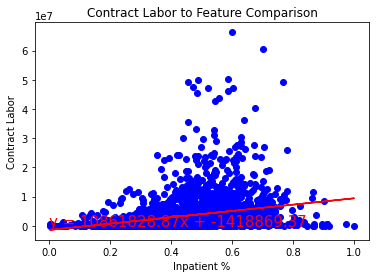

The correlation coefficient is 0.3
The line equation is as follows:  y = 10861828.87x + -1418869.37


In [123]:
#Comparing Contract Labor to Inpatient Percent
x_axis = mainFile5["Inpatient %"]
y_axis = mainFile5["Contract Labor"]
plt.title("Contract Labor to Feature Comparison")
plt.xlabel("Inpatient %")
plt.ylabel("Contract Labor")
plt.scatter(x_axis, y_axis, marker="o", color="blue")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
#plt.savefig("3bchart_days2unemployment_k.png")
plt.show()
print(f"The correlation coefficient is {round(st.pearsonr(x_axis,y_axis)[0],2)}")
print(f"The line equation is as follows:  {line_eq}")

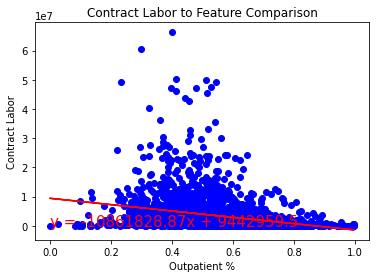

The correlation coefficient is -0.3
The line equation is as follows:  y = -10861828.87x + 9442959.5


In [124]:
#Comparing Contract Labor to Outpatient Percent
x_axis = mainFile5["Outpatient %"]
y_axis = mainFile5["Contract Labor"]
plt.title("Contract Labor to Feature Comparison")
plt.xlabel("Outpatient %")
plt.ylabel("Contract Labor")
plt.scatter(x_axis, y_axis, marker="o", color="blue")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
#plt.savefig("3bchart_days2unemployment_k.png")
plt.show()
print(f"The correlation coefficient is {round(st.pearsonr(x_axis,y_axis)[0],2)}")
print(f"The line equation is as follows:  {line_eq}")

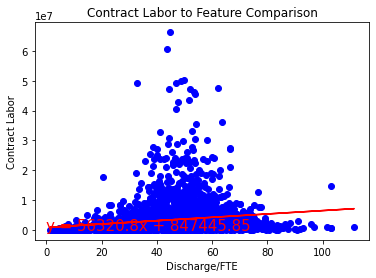

The correlation coefficient is 0.16
The line equation is as follows:  y = 56320.8x + 847445.85


In [126]:
#Comparing Contract Labor to Discharges/FTE
x_axis = mainFile5["Discharge/FTE"]
y_axis = mainFile5["Contract Labor"]
plt.title("Contract Labor to Feature Comparison")
plt.xlabel("Discharge/FTE")
plt.ylabel("Contract Labor")
plt.scatter(x_axis, y_axis, marker="o", color="blue")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
#plt.savefig("3bchart_days2unemployment_k.png")
plt.show()
print(f"The correlation coefficient is {round(st.pearsonr(x_axis,y_axis)[0],2)}")
print(f"The line equation is as follows:  {line_eq}")

In [119]:
#End ... kent matthew rodgers, profitableHospital-project

In [ ]:
# Useful scraps

In [ ]:
# geoTable.drop_duplicates(inplace = True)
# geoTable['Provider CCN'].count()
#df.count()
#mainFile1['Provider CCN'].duplicated()